# ML Pipeline using Sagemaker Clarify

In [3]:
!./setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [4]:
# Load libraries
import sagemaker
import boto3
from sagemaker import Session, get_execution_role, local, Model, utils, fw_utils, s3
import pandas as pd
import numpy as np
import urllib
import os
import time
from time import strftime

sess = boto3.Session(region_name='ap-southeast-1')
session = sagemaker.Session(boto_session=sess)
region = session.boto_region_name
role = get_execution_role()
region = session.boto_region_name
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
    )
account = client.get_caller_identity()['Account']
bucket = 'ml-innovate-2021'
prefix = 'clarify-test'
create_date = strftime("%Y-%m-%d-%H-%M-%S")
print(create_date)
new_prefix = os.path.join(prefix, f'Exp-{create_date}')

2021-01-24-03-30-16


### Download Data

In [5]:
adult_columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
                 "Occupation", "Relationship", "Ethnic group", "Gender", "Capital Gain", "Capital Loss",
                 "Hours per week", "Country", "Target"]

urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data','adult.data')
print('adult.data saved!')

urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test','adult.test')
print('adult.test saved!')

adult.data saved!
adult.test saved!


### Prepare Data

In [6]:
training_data = pd.read_csv("adult.data",
                             names=adult_columns,
                             sep=r'\s*,\s*',
                             engine='python',
                             na_values="?").dropna()

testing_data = pd.read_csv("adult.test",
                            names=adult_columns,
                            sep=r'\s*,\s*',
                            engine='python',
                            na_values="?",
                            skiprows=1).dropna()

In [7]:
training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Gender,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


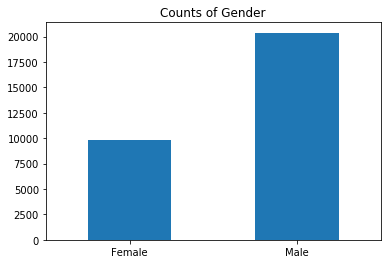

In [10]:
# Visualize distribution of protected attribute
training_data['Gender'].value_counts().sort_values().plot(kind='bar', title='Counts of Gender', rot=0)

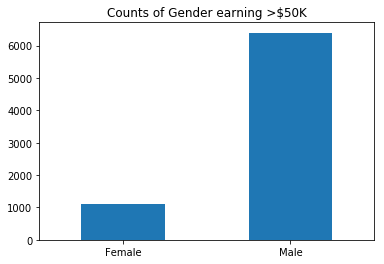

In [9]:
# Visualize distribution of outcome corresponding to protected attribute
training_data['Gender'].where(training_data['Target']=='>50K').value_counts().sort_values().plot(kind='bar', title='Counts of Gender earning >$50K', rot=0)

In [11]:
# Encode Female to '0' and Male to '1'
from sklearn import preprocessing
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
    return result, encoders

training_data = pd.concat([training_data['Target'], training_data.drop(['Target'], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv('train_data.csv', index=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(['Target'], axis = 1)
test_target = testing_data['Target']
test_features.to_csv('test_features.csv', index=False)

In [12]:
# Upload data to S3
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload('train_data.csv', 's3://{}/{}'.format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type='text/csv')
test_uri = S3Uploader.upload('test_features.csv', 's3://{}/{}'.format(bucket, prefix))
print('train_uri:', train_uri)
print('train_input:', train_input)
output_path = f's3://{bucket}/{prefix}/{create_date}/output'

train_uri: s3://ml-innovate-2021/clarify-test/train_data.csv
train_input: <sagemaker.inputs.TrainingInput object at 0x7fce590f1160>


### Pre-Training Fairness Assessment

In [13]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=session)

In [14]:
bias_report_output_path = 's3://{}/{}/clarify-bias-{}'.format(bucket, prefix, create_date)
bias_data_config = clarify.DataConfig(s3_data_input_path=train_uri,
                                      s3_output_path=bias_report_output_path,
                                      label='Target',
                                      headers=training_data.columns.to_list(),
                                      dataset_type='text/csv')

bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='Gender',
                                facet_values_or_threshold=[0],
                                group_name='Education')

In [15]:
clarify_processor.run_pre_training_bias(data_config=bias_data_config,
                                        data_bias_config=bias_config, 
                                        methods='all', 
                                        wait=True, 
                                        logs=True, 
                                        job_name=f'pretraining-bias-{create_date}')


Job Name:  pretraining-bias-2021-01-24-03-30-16
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/pretraining-bias-2021-01-24-03-30-16/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/clarify-bias-2021-01-24-03-30-16', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
................................INFO:sagemake

### Training: HPO

In [16]:
from sagemaker.estimator import Estimator

new_prefix = os.path.join(prefix, f'Exp-{create_date}')

hyperparameters = {
    "max_depth": "10",
    "eta": "1",
    "gamma": "1",
    "min_child_weight": "6",
    "objective": 'binary:logistic',
    "num_class": "2",
    "num_round": "40",
    "s3_bucket": os.path.join(bucket, new_prefix, 'debug'),
    "protected": "Gender",
    "thresh": "0.8"
}

output_path = 's3://{0}/{1}/output/'.format(bucket, new_prefix)

estimator = Estimator(
    image_uri='963992372437.dkr.ecr.ap-southeast-1.amazonaws.com/clarify-xgb:latest',
    role=role,
    sagemaker_session=session,
    instance_count=1,
    instance_type='ml.m5.4xlarge',
    output_path=output_path,
    hyperparameters=hyperparameters
)

In [18]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter
from time import gmtime, strftime

hyperparameter_ranges = {
    'eta': ContinuousParameter(1,2),
    #'alpha': ContinuousParameter(0,1000),
    'gamma': IntegerParameter(1,5),
    'min_child_weight': IntegerParameter(1,10),
    'max_depth': IntegerParameter(1,10),
    "num_round": IntegerParameter(4,30)
}

metric_definitions = [{'Name': 'validation-f1',
                       'Regex': 'validation-f1: ([0-9\\\\.]+)'}]

# Configure HyperparameterTuner
my_tuner = HyperparameterTuner(estimator=estimator,
                               objective_metric_name='validation-f1',
                               objective_type='Maximize',
                               hyperparameter_ranges=hyperparameter_ranges,
                               metric_definitions=metric_definitions,
                               strategy='Random',
                               max_jobs=100,
                               max_parallel_jobs=10)

# Start hyperparameter tuning job
tuning_job_name = "tuning-{}".format(create_date)
my_tuner.fit({'train': train_input}, wait=False, include_cls_metadata=False, job_name=tuning_job_name)

In [21]:
my_tuner.describe()['HyperParameterTuningJobStatus']

'Completed'

In [22]:
tuning_job_name

'tuning-2021-01-24-03-30-16'

### Finding the Best Model: On Performance

In [23]:
df=my_tuner.analytics().dataframe().sort_values(['FinalObjectiveValue'], ascending=False)
df

,eta,gamma,max_depth,min_child_weight,num_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
93,1.173980,4.0,6.0,2.0,16.0,tuning-2021-01-24-03-30-16-007-fc9c0709,Completed,0.725565,2021-01-24 03:39:51+00:00,2021-01-24 03:41:14+00:00,83.0
55,1.379901,2.0,7.0,5.0,30.0,tuning-2021-01-24-03-30-16-045-2d9b0c8e,Completed,0.724415,2021-01-24 03:54:09+00:00,2021-01-24 03:55:37+00:00,88.0
3,1.280386,2.0,6.0,9.0,6.0,tuning-2021-01-24-03-30-16-097-d48d1a75,Completed,0.723208,2021-01-24 04:12:51+00:00,2021-01-24 04:14:03+00:00,72.0
83,1.559073,5.0,8.0,1.0,25.0,tuning-2021-01-24-03-30-16-017-77ef408f,Completed,0.723072,2021-01-24 03:43:45+00:00,2021-01-24 03:45:12+00:00,87.0
89,1.281997,1.0,4.0,10.0,27.0,tuning-2021-01-24-03-30-16-011-ab7d58e6,Completed,0.722959,2021-01-24 03:43:13+00:00,2021-01-24 03:44:39+00:00,86.0
...,...,...,...,...,...,...,...,...,...,...,...
27,1.582956,2.0,2.0,2.0,12.0,tuning-2021-01-24-03-30-16-073-b5d56cfd,Completed,0.640264,2021-01-24 04:05:01+00:00,2021-01-24 04:06:18+00:00,77.0
56,1.823969,3.0,2.0,2.0,28.0,tuning-2021-01-24-03-30-16-044-b3be7e86,Completed,0.639320,2021-01-24 03:54:32+00:00,2021-01-24 03:55:53+00:00,81.0
15,1.575077,1.0,2.0,4.0,10.0,tuning-2021-01-24-03-30-16-085-a2b4e8a2,Completed,0.633004,2021-01-24 04:08:45+00:00,2021-01-24 04:10:03+00:00,78.0
66,1.795090,2.0,1.0,8.0,10.0,tuning-2021-01-24-03-30-16-034-c23b7622,Completed,0.607916,2021-01-24 03:50:25+00:00,2021-01-24 03:51:48+00:00,83.0


In [25]:
from sagemaker.s3 import S3Downloader
import tarfile
import pickle as pkl
import xgboost

smclient=boto3.client('sagemaker',region_name='ap-southeast-1')
trjobs = smclient.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    MaxResults=100,
    SortBy='FinalObjectiveMetricValue',
    SortOrder='Descending')

trjob = trjobs['TrainingJobSummaries'][0]
exp_destination = os.path.join('s3://', bucket, new_prefix)
model_path = os.path.join(exp_destination,'output',trjob["TrainingJobName"],'output','model.tar.gz')

In [26]:
model_path

's3://ml-innovate-2021/clarify-test/Exp-2021-01-24-03-30-16/output/tuning-2021-01-24-03-30-16-007-fc9c0709/output/model.tar.gz'

### Deploy Model

In [27]:
from sagemaker.xgboost.model import XGBoostModel

xgboost_model = XGBoostModel(
    model_data=model_path,
    role=role,
    entry_point="container/inference.py",
    framework_version="1.2-1"
)

In [28]:
predictor = xgboost_model.deploy(
    endpoint_name="testing-clarify1-endpoint-{}".format(create_date),
    instance_type='ml.m4.xlarge',
    initial_instance_count=1
)
predictor.serializer = sagemaker.serializers.CSVSerializer(content_type='text/csv')

---------------!

In [29]:
print(xgboost_model.name)

sagemaker-xgboost-2021-01-24-04-19-55-315


In [30]:
X=test_features.to_numpy()
print(predictor.predict(X[0]))
res = []
for i in range(0,len(X),10):
    t=predictor.predict(X[i:i+10])
    res.extend([x[0] for x in t])

[['0.0012154273', '-1.4287672', '0.0026163142', '0.021897709', '0.30380577', '-1.0189961', '-0.9647735', '-0.26010045', '-1.004088', '-0.26631093', '0.03459386', '-0.1598824', '-0.025414063', '-0.08231749', '-0.20690636', '-1.6568005']]


In [50]:
pred = [float(r) for r in res]
tr = list(testing_data['Target'].to_numpy())

In [51]:
from sklearn.metrics import f1_score
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference
from fairlearn.metrics import selection_rate

def fair_metrics(tr,pred,column,thresh):
    pred = [1 if p > thresh else 0 for p in pred]
    na0=0
    na1=0
    nd0=0
    nd1=0
    for p,c in zip(pred,column):
        if (p==1 and c==0):
            nd1 += 1
        if (p==1 and c==1):
            na1 += 1
        if (p==0 and c==0):
            nd0 += 1
        if (p==0 and c==1):
            na0 += 1
    Pa1, Pd1, Pa0, Pd0 = na1/(na1+na0), nd1/(nd1+nd0), na0/(na1+na0), nd0/(nd1+nd0)
    dsp_metric = np.abs(Pd1-Pa1)
    sr_metric = selection_rate(tr, pred, pos_label=1)
    dpd_metric = demographic_parity_difference(tr, pred, sensitive_features=column)
    dpr_metric = demographic_parity_ratio(tr, pred, sensitive_features=column)
    eod_metric = equalized_odds_difference(tr, pred, sensitive_features=column)
    f1_metric = f1_score(tr, pred, average='macro')
    
    return f1_metric, dsp_metric, sr_metric, dpd_metric, dpr_metric, eod_metric

protected_col = list(testing_data['Gender'].to_numpy())
thresh = 0.8
f1_metric, dsp_metric, sr_metric, dpd_metric, dpr_metric, eod_metric = fair_metrics(tr,pred,protected_col,thresh)
print('f1_metric: ',f1_metric)
print('dsp_metric: ',dsp_metric)
print('sr_metric: ',sr_metric)
print('dpd_metric: ',dpd_metric)
print('dpr_metric: ',dpr_metric)
print('eod_metric: ',eod_metric)

f1_metric:  0.7132269603177037
dsp_metric:  0.08899609287138739
sr_metric:  0.09721115537848606
dpd_metric:  0.08899609287138739
dpr_metric:  0.2950481230554506
eod_metric:  0.07816235217641893


### Visual Assessment of Test Data

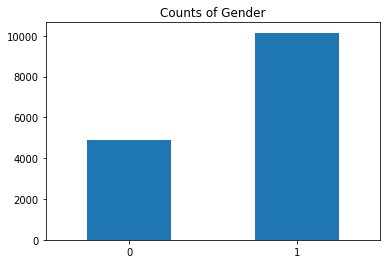

In [31]:
# Visualize distribution of protected attribute
testing_data['Gender'].value_counts().sort_values().plot(kind='bar', title='Counts of Gender', rot=0)

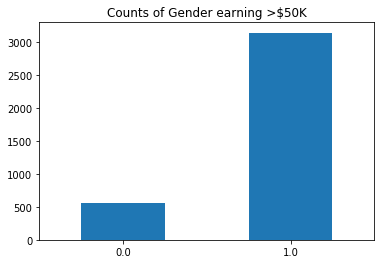

In [32]:
# Visualize distribution of outcome corresponding to protected attribute
testing_data['Gender'].where(testing_data['Target']==1).value_counts().sort_values().plot(kind='bar', title='Counts of Gender earning >$50K', rot=0)

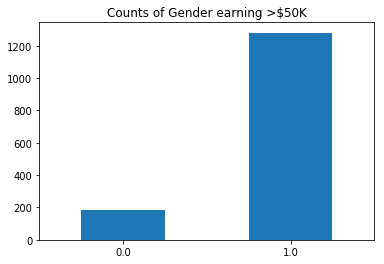

In [33]:
res_val=[1 if float(r) >= 0.8 else 0 for r in res]
testing_result = testing_data.copy()
testing_result['Pred_Target'] = np.array(res_val)
testing_result['Gender'].where(testing_result['Pred_Target']==1).value_counts().sort_values().plot(kind='bar', title='Counts of Gender earning >$50K', rot=0)

### Post-Training Fairness Assessment - Training Data

In [34]:
model_name = xgboost_model.name
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [35]:
clarify_processor.run_post_training_bias(data_config=bias_data_config,
                                         data_bias_config=bias_config,
                                         model_config=model_config,
                                         model_predicted_label_config=predictions_config,
                                         methods='all',
                                         wait=True,
                                         logs=True,
                                         job_name=f'posttraining-bias-{create_date}')


Job Name:  posttraining-bias-2021-01-24-03-30-16
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/posttraining-bias-2021-01-24-03-30-16/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/clarify-bias-2021-01-24-03-30-16', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.................................INFO:sagem

### Explaining Predictions - Training Data

In [36]:
shap_config = clarify.SHAPConfig(baseline=[test_features.iloc[0].values.tolist()],
                                 num_samples=15,
                                 agg_method='mean_abs')

explainability_output_path = 's3://{}/{}/clarify-explainability-{}'.format(bucket, prefix, create_date)
explainability_data_config = clarify.DataConfig(s3_data_input_path=train_uri,
                                s3_output_path=explainability_output_path,
                                label='Target',
                                headers=training_data.columns.to_list(),
                                dataset_type='text/csv')

In [37]:
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)


Job Name:  Clarify-Explainability-2021-01-24-05-24-04-977
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/Clarify-Explainability-2021-01-24-05-24-04-977/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/clarify-explainability-2021-01-24-03-30-16', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...............

### Post-Training Fairness Assessment - Testing Data

In [42]:
testing_data.to_csv('testing_data.csv', index=False)
testing_uri = S3Uploader.upload('testing_data.csv', 's3://{}/{}'.format(bucket, prefix))

In [43]:
test_bias_report_output_path = 's3://{}/{}/clarify-bias-test-{}'.format(bucket, prefix, create_date)
test_bias_data_config = clarify.DataConfig(s3_data_input_path=testing_uri,
                                      s3_output_path=test_bias_report_output_path,
                                      label='Target',
                                      headers=testing_data.columns.to_list(),
                                      dataset_type='text/csv')

test_bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='Gender',
                                facet_values_or_threshold=[0],
                                group_name='Education')

In [44]:
clarify_processor.run_post_training_bias(data_config=test_bias_data_config,
                                         data_bias_config=test_bias_config,
                                         model_config=model_config,
                                         model_predicted_label_config=predictions_config,
                                         methods='all',
                                         wait=True,
                                         logs=True,
                                         job_name=f'posttesting--bias-{create_date}')


Job Name:  posttesting--bias-2021-01-24-03-30-16
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://ml-innovate-2021/clarify-test/testing_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-1-963992372437/posttesting--bias-2021-01-24-03-30-16/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://ml-innovate-2021/clarify-test/clarify-bias-test-2021-01-24-03-30-16', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.................................INF